# Creation of Simple Neural Network <br>
In this notebook, we annotate and provide explanations on the creation of a simple neural network. The creation of this network follows <br>
> https://www.youtube.com/watch?v=VMj-3S1tku0

One of the most important things to understand in a neural network is the concept of a derivative. We construct an example of a function to give intuition to the reader of what a derivative is and what it means. We start with a standard polynomial that is easy to differentiate via power rule. Remember that a derivative is an instinaneous rate of change, i.e. it can be used to show how small changes of x will affect the out put

In [56]:
#import some standard packages
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

#define our function
def f(x):
    return 3*x**2 - 4*x + 5

Below we evaluate the function at x=3. The reader is now encourage to change this x value by small amounts (within the range of plus or minus 0.1). Note the impact these changes have. Divide the change in output by the change input. This is a rate of change.

In [57]:
f(3.0)

20.0

We now graph the function. We encourage the reader to attempt to copy the graph and draw a line tangent to the graph at x = 3. Calculate the slope of this line. Is it close to what calculated the rate of change to be above?

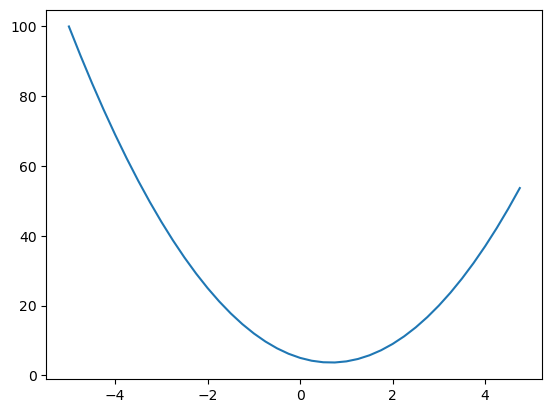

In [58]:
xs = np.arange(-5,5,.25)
ys = f(xs)
ys
plt.plot(xs,ys)

The derivative function of f(x), denoted f'(x), is the following:<br>
> $f'(x) =6x +4$

Thus, plugging in x = 3 into this function, we get the derivatie at x= 3 is 22. This should hopefully be close to your slope and rate of change from the two prior exercises. If you wish to practice derivative, we encourage you to look at the following link<br>

> https://tutorial.math.lamar.edu/classes/calcI/DerivativeIntro.aspx

## Why Do We care about derivatives? 

The basic goal of our neural network is to change the weights of inputs in order to get close to a desired output. In order to makes these changes in an informed measure, we wish to measure the impact that changing a specific weight has to the output. This measure is, infact, a derivative. It is the partial derivative of the weight with respect to the output. If you wish to read about partial derivatives, we refer to <br>

> https://tutorial.math.lamar.edu/Classes/CalcIII/PartialDerivatives.aspx

In calculating our partial derivatives, we will use back propigation and change of variable theorems. An intuitive interpretation is found here <br>

>https://en.wikipedia.org/wiki/Chain_rule

However, in order to backpropogate and keep track of partial derivatives, we need to introduce a new class to store this information in. Our goals are as followed:<br>
1. We want for the class to be able to perform standard math operations
2. We want the class to be able to store a partial derivative
3. We want the class to calculate the partial derivative on its own if it knows the next one
4. We want the class to keep track of what operations were performed on which objects in order to get to this point
5. We want the class to be labeled for ease of reading

In order to achieve these goals we build the following class:

In [59]:
class value:
    
    def __init__(self, data, _children=(), _op='', label = ''): #initilization
        self.data = data #store value
        self.grad = 0.0 #store partial derivative
        self._backward = lambda: None #how to calculate partial
        self._prev = set(_children) #store from where
        self._op = _op #store method to get here
        self.label = label #label for ease of reading
        
    def __repr__(self): #what will be printed if you call a value object
        return f"Value(data={self.data})"

    #Our two most important operators are addition and multiplication. Almost every other
    #operation can be born from these two opperations.
    def __add__(self,other): #how to define addition
        other = other if isinstance(other, value) else value(other) #making sure you can add with type integer and float too
        out = value(self.data + other.data, (self, other), '+')
        def _backward(): #keeping track of partial derivative with respect to the output 
            self.grad += 1.0 * out.grad #the += is so that if the variable is contributing multiple times, it does not overwrite each time
            other.grad += 1.0 * out.grad
        out._backward = _backward #so it calculates the partial correctly
        return out

    def __radd__(self, other): #incase first part of addition is int or float
        return self+other

    def __mul__(self,other): #comments largely the same as on addition
        other = other if isinstance(other, value) else value(other)
        out = value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data *out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other): #incase first part of mult is int or float
        return self*other

    def __neg__(self): #defining negative number
        return self*-1

    def __sub__(self,other): #defining subtraction
        return self + (-other)

    def exp(self): #defining e^x
        x = self.data
        out = value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    

    def __pow__(self,n): #defining x^n
        assert isinstance(n, (int, float))
        x = self.data
        out = value(x**n, (self,), f'**{n}')

        def _backward():
            self.grad += n*x**(n-1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): #defining division
        return self * other**-1

    def tanh(self): #example non-zero function we will use
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out

    def backward(self): #order graph in order to back propogate partial derivatives
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        self.grad = 1
        
        for node in reversed(topo):
            node._backward()

Going forward, to build intution, we wish to visualize what is happening under the hood. The following does exactly that. It is not imperative to understand what is happening here.  

In [60]:
from graphviz import Digraph

def trace(root):
    vertices, edges = set(), set()
    def build(v):
        if v not in vertices:
            vertices.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return vertices, edges

def draw_dot(root):
    dot = Digraph(format ='svg', graph_attr={'rankdir': 'LR'})
    vertices, edges = trace(root)

    for n in vertices:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

Let us now recap what we've done so far. We have defined a variable that, once you choose an end point, it able to back propogate partial derivates with respect to that output. We also defined a function that uses this information in order to form a directed graph that combines input to their respective out puts, tells you how they combined, projects their name and their partial derivative. We now show an example in order to provide intuition.

In [61]:
a = value(2.0, label = 'a')
b = value(-3.0, label = 'b')
c = value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L.backward()

Note, we can rewrite L to be the following function<br>
> $L(a,b,c,f) = ((a*b)+c)*f$ <br>

We encourage again to play with small intervals around each variable in order to gain intuition as to what their derivative may be. Below is a graph that illustrates the function and the variables derivative.

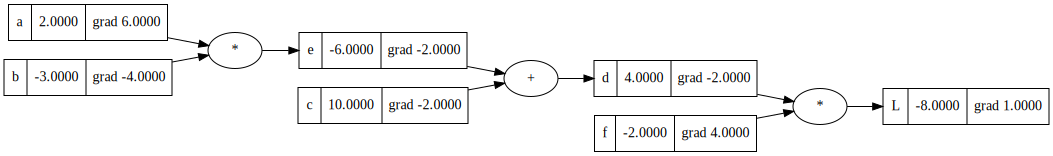

In [62]:
draw_dot(L)

Now, for neural network, all of the inputs will have weights. Our goal is to be able to manipulate these weights in order to get the output with a given set of inputs to match a goal. In order to see the influence of weights we introduce the following example

In [63]:
x1 = value(2.0, label = 'x1')
x2 = value(0, label = 'x2')
w1 = value(-3.0, label = 'w1')
w2= value(1, label = 'w2')
b = value(6.8813735870195432, label = 'b')
w1x1 = x1 * w1; w1x1.label = 'w1x1'
w2x2 = x2 * w2; w2x2.label = 'w2x2'
sumate = w1x1 + w2x2; sumate.label = 'x1w1+x2w2'
n = sumate + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

We can write o as the following function <br>
> $o(x1,x2,w1,w2,b) = \tanh (x1*w1 +x2*w2 + b)$

Again, we encourage the reader to predict partial derivatives before looking at the graph below

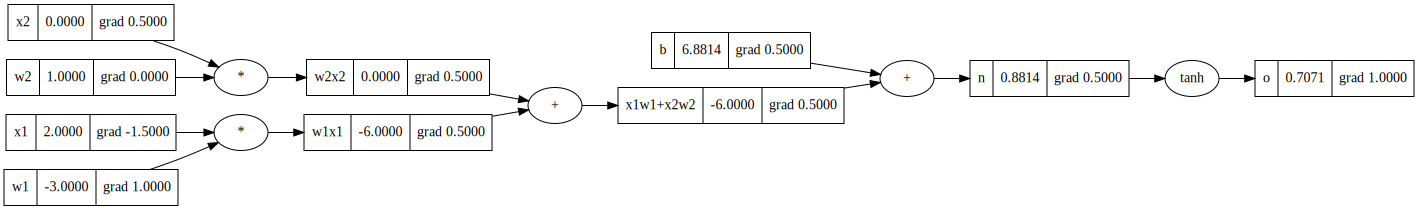

In [64]:
draw_dot(o)

We now show that the common package pytorch achieves everything we've done so far. Our work however isn't for naught. In building the tools ourselves we gain the ability to better tweak our model and also gain a more intuitive understanding of what is happening under the hood.

In [65]:
import torch
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813736870195432]).double(); b.requires_grad = True
n = x1*w1+x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('______')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071069288235958
______
x2 0.4999997912096622
w2 0.0
x1 -1.4999993736289867
w1 0.9999995824193244


We now build a class that given a set of inputed values able to output a set of predictions. It auto assigns weights and biases and auto builds layers of function. For us, it is composotion of the same function a given number of times. o This class is to give intuitions about the above tensors on more complex functions and data sets. 

In [66]:
class neuron:
    def __init__(self, nin):
        self.w = [value(random.uniform(-1,1)) for _ in range (nin)] #Creates Weights of each input
        self.b = value(random.uniform(-1,1)) #Creates Bias controlls trigger happy

    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)#the self.b is equivalent to adding it, but faster for some reason?
        out = act.tanh()
        return out

    def parameters(self):#Note, this was added after first viewing the loss graph
        return self.w + [self.b]  #gives a list of the weights and bs

class layer:
    def __init__(self, nin,nout):
        self.neurons = [neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] #below can see what this code is actually doing
#        params = []
#        for neuron in self.neurons:
#            ps = neuron.parameters()
#            params.extend(ps)
#        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

We provide a 'simple' example of what is going on here. Take your time and try to understand the graph below. if you wish to simply if the graph, simply change the [4,4,1] in the second row to something like [2,1]. However, changing this will impact our predictions below and weaken our model. 

Note, MLP(3,[4,4,1]) is saying that we are feeding in 3 inputs, it will calculate through 3 layers, in the first layer there are four functions with the given inputs. In the next layer there are four functions with the given output of the first layer. And the final layer takes the four outputs of the second layer and outputs them to a single value. The graph is most likely easier to build in reverse.

One further goal is to auto fill in labels for the neuron networks.

In [90]:
x = [1.0,2.0, -3.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.9261883891607104)

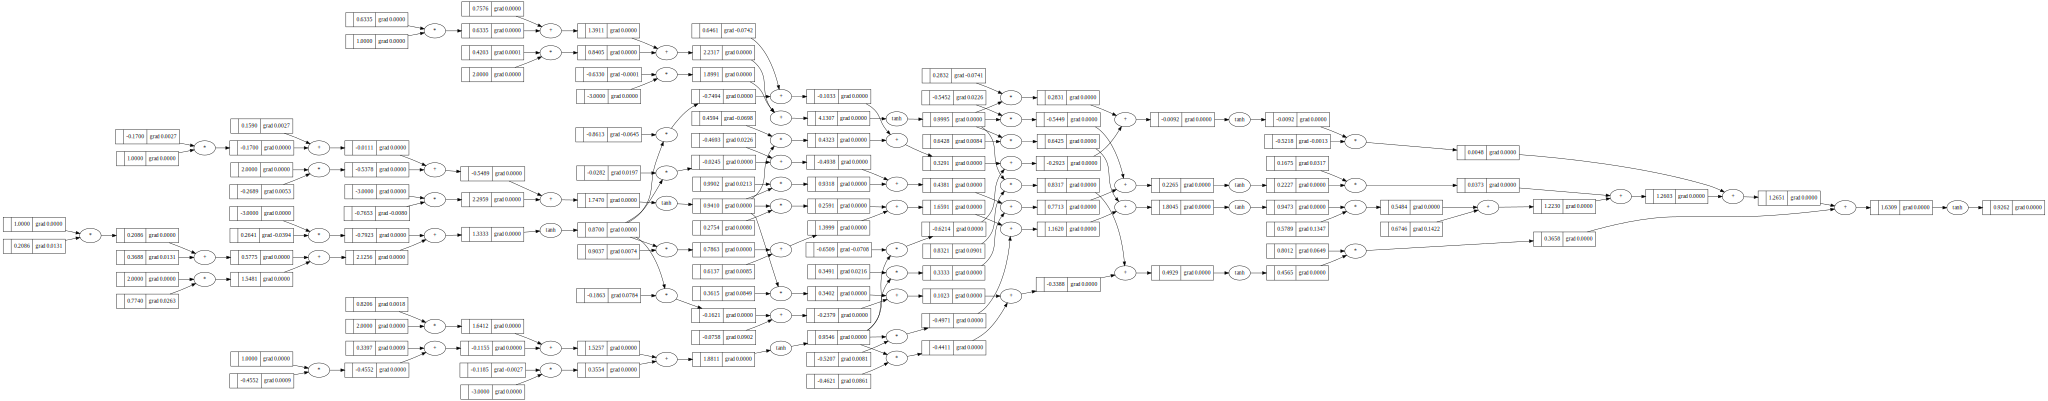

In [91]:
n(x).backward()
draw_dot(n(x))

One interesting thing to observe here is that for some reason our n(x) will not track gradiants. I'm not sure why this is occuring at the moment and will be looking for bug fixes at a later point. I believe what is happening is that the values are actually just really small, but then there is no reason why n(x).grad should be 0. n(x).grad should always be 1. There is a bug somewhere

We now want to give a larger set of data in order to show the full capability of this network

In [70]:
xs = [
    [3.0, 4.0, -2.0],
    [4.0,-2.0,1.0],
    [1.0, 2.0, 2.0],
    [2.0,2.0,-2.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

Here are our sets of inputs and a set of desired outputs. We now want to know what our model is predicting for each output. 

In [71]:
ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.4043448645925506), Value(data=-0.8080603361165639), Value(data=-0.5625360339915889), Value(data=0.15019368681487183)]
Value(data=1.3051913663940615)


Next we want to have some sort of measure of how far our prediction is from our goal. We use a measure inspired by standard deviation calculations and the euclidean norm

In [93]:
loss = sum((yout - yobs)**2 for yobs, yout in zip(ys, ypred))
print(loss)

Value(data=0.0434888584047744)


Our goal is to now minimize this loss. In order to do this, we want to look at the partial derivatives of inputs with respect to loss. We visualize this with a directed graph and show to retrieve an individul partial. Note, it will be more useful for the reader to look at individual partials via the pull method shown in three lines. The graph, while it can be understood, is not worth the hair loss required to figure out where everything is.

In [72]:
loss.backward()

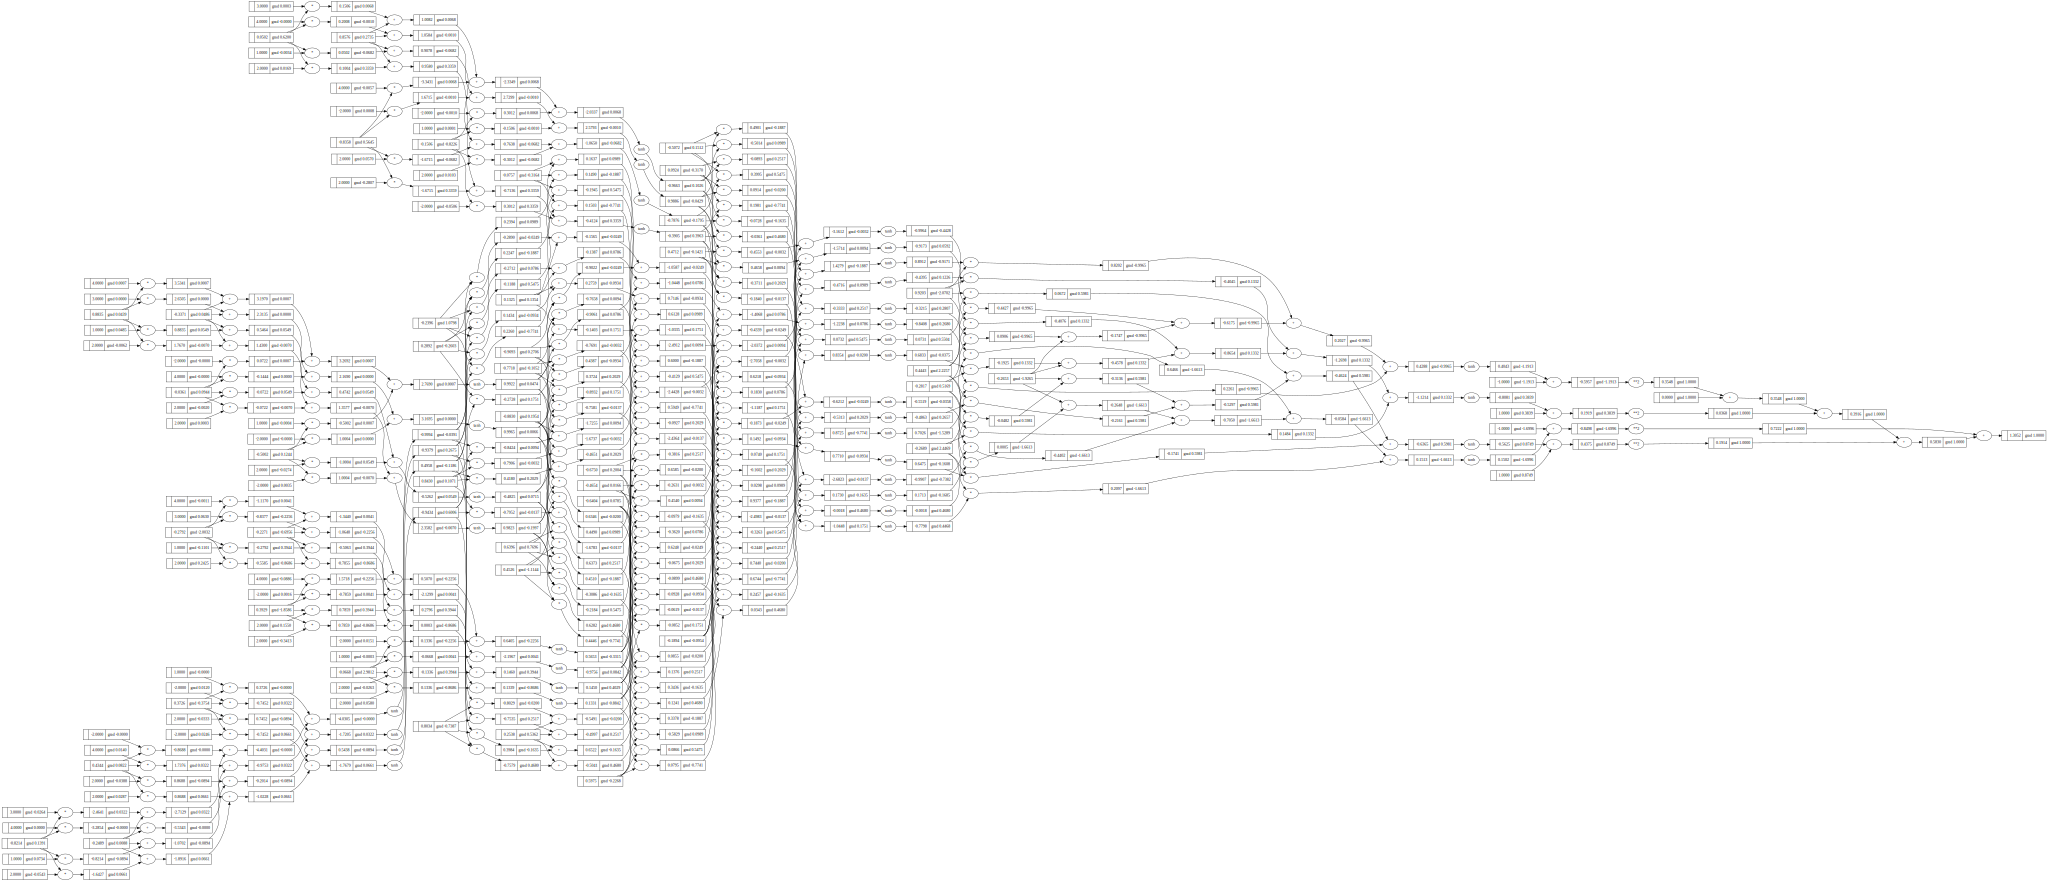

In [73]:
draw_dot(loss)

In [74]:
n.layers[0].neurons[0].w[0].grad

0.13910907466542194

So the gradiants are only useful on the ws and on the bs. The inputs are assumed to be fixed, so we do not care about their partial derivates as it is a measure on how changing them impacts to total loss. We can look at these ws and bs as a set/list of parameters by calling the following function. 

In [75]:
n.parameters()

[Value(data=-0.8213560930268384),
 Value(data=0.43440676269339695),
 Value(data=0.3725862130566713),
 Value(data=-0.24885565608626536),
 Value(data=0.8835131186252669),
 Value(data=-0.03610463433231215),
 Value(data=-0.5002148510005231),
 Value(data=-0.3370746692876392),
 Value(data=-0.279247363825581),
 Value(data=0.392942503991087),
 Value(data=-0.06678662791930723),
 Value(data=-0.22705491379817144),
 Value(data=0.05019522592026404),
 Value(data=-0.8357655401655935),
 Value(data=-0.1506025149401924),
 Value(data=0.8575699181319154),
 Value(data=0.8034216184404663),
 Value(data=0.6395726938311184),
 Value(data=-0.6750231027297351),
 Value(data=0.09242088625223799),
 Value(data=0.25381483379350156),
 Value(data=0.8429587126022269),
 Value(data=-0.7718179667234559),
 Value(data=-0.46536685513621934),
 Value(data=0.4712017951716809),
 Value(data=-0.8830365531820117),
 Value(data=-0.23960059886137142),
 Value(data=0.4525819064459997),
 Value(data=0.5975035900895056),
 Value(data=-0.50721

Now we give an example of changing our parameters based off of their partial derivatives and observe how it has affected out loss

In [94]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [95]:
ypred = [n(x) for x in xs]
loss = sum((yout - yobs)**2 for yobs, yout in zip(ys, ypred))
loss

Value(data=3.449287420994558)

In [79]:
loss.backward()

We also get to see how it has updates out predictions below. Note how they are closer to their goals of (1,-1,-1,1)

In [80]:
ypred

[Value(data=0.9050811562615194),
 Value(data=-0.4177526350294303),
 Value(data=-0.502693101351853),
 Value(data=0.8984499732547111)]

Now we want to loop this process. We reset our inputs and our prediction and then run the process a given number of times. Change the amount of runs and see how it betters our loss and predicted values

In [81]:
x = [20.0,15.0, -21.0]
n = MLP(3,[4,4,1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0,0.5],
    [0.5, 1.0, 1.0],
    [1.0,1.0,-1.0]
]

ys = [1, -1, 1, 1] #desired targets

In [82]:
total_runs = 10
for k in range(total_runs):
    ypred = [n(x) for x in xs]
    loss = sum((yout - yobs)**2 for yobs, yout in zip(ys, ypred))
    #reset gradiants so they dont just add up perpetually
    for p in n.parameters():
        p.grad = 0

    y = 1 - 0.9*(k/total_runs)
    
    loss.backward()
    for p in n.parameters():
        p.data -= .1 * p.grad

In [83]:
print(loss)

Value(data=0.0434888584047744)


In [84]:
ypred

[Value(data=0.9523504448210881),
 Value(data=-0.8466525574739285),
 Value(data=0.8849135116511417),
 Value(data=0.933231441783819)]